<a href="https://colab.research.google.com/github/ayusri1/dark-psi/blob/main/SPY500_day_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance pandas matplotlib

In [ ]:
import yfinance as yf
import pandas as pd

print("Downloading SPY data...")
data = yf.download('SPY', start='1990-01-01', end='2024-12-31')
print("Downloaded rows:", len(data))
print("Columns:", data.columns)

# ---- FIX: Flatten MultiIndex columns if present ----
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join([str(i) for i in col if i]).strip() for col in data.columns.values]
    print("Flattened columns:", data.columns)

# ---- Use flattened names ----
close_col = [c for c in data.columns if c.startswith('Close')][0]

# Convert index to datetime if needed
if not pd.api.types.is_datetime64_any_dtype(data.index):
    data.index = pd.to_datetime(data.index)

if data.empty:
    print("ERROR: DataFrame is empty!")
else:
    data['Return_'] = data[close_col].pct_change()
    data['Result_'] = data['Return_'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'flat'))
    data['Month-Day_'] = data.index.strftime('%m-%d')
    print("\nCurrent columns:", data.columns)
    print(data[['Month-Day_', 'Result_', 'Return_']].head(10))
    print(data[['Month-Day_', 'Result_', 'Return_']].tail(10))
    print(data[['Month-Day_', 'Result_', 'Return_']].isnull().sum())

    # Now groupby with new names
    calendar_stats = (
        data.groupby('Month-Day_')
        .agg(
            total_days=('Result_', 'count'),
            green_days=('Result_', lambda x: (x == 'green').sum()),
            red_days=('Result_', lambda x: (x == 'red').sum()),
            avg_return=('Return_', 'mean')
        )
        .reset_index()
    )
    print("\nGrouped stats sample:")
    print(calendar_stats.head())

    calendar_stats['green_pct'] = calendar_stats['green_days'] / calendar_stats['total_days'] * 100
    calendar_stats['red_pct'] = calendar_stats['red_days'] / calendar_stats['total_days'] * 100

    # Calendar order
    calendar_stats['Month-Day_'] = pd.to_datetime('2020-' + calendar_stats['Month-Day_'])
    calendar_stats = calendar_stats.sort_values('Month-Day_')
    calendar_stats['Month-Day_'] = calendar_stats['Month-Day_'].dt.strftime('%m-%d')

    print("\nFinal stats sample:")
    print(calendar_stats.head())

    calendar_stats.to_csv('spy_calendar_day_stats_1990_2024.csv', index=False)
    print("\nSaved to spy_calendar_day_stats_1990_2024.csv")

/tmp/ipython-input-651421726.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('SPY', start='1990-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed

Downloaded rows: 8037
Columns: MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])
Flattened columns: Index(['Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY'], dtype='object')

Current columns: Index(['Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY', 'Return_',
       'Result_', 'Month-Day_'],
      dtype='object')
           Month-Day_ Result_   Return_
Date                                   
1993-01-29      01-29    flat       NaN
1993-02-01      02-01   green  0.007111
1993-02-02      02-02   green  0.002119
1993-02-03      02-03   green  0.010571
1993-02-04      02-04   green  0.004184
1993-02-05      02-05     red -0.000695
1993-02-08      02-08    flat  0.000000
1993-02-09      02-09     red -0.006950
1993-02-10      02-10   green  0.001400
1993-02-11      02-11   green  0.004892
           Month-Day_ Result_   Retur

In [ ]:
# Extract month names
import calendar
calendar_stats['month'] = calendar_stats['Month-Day_'].str[:2].astype(int).apply(lambda x: calendar.month_abbr[x])
calendar_stats['day'] = calendar_stats['Month-Day_'].str[3:].astype(int)

# Make a combined label like 'Jan 10'
calendar_stats['month_day_label'] = calendar_stats['month'] + ' ' + calendar_stats['day'].astype(str)


In [ ]:
xtick_locs = []
xtick_labels = []
for month in calendar.month_abbr[1:]:  # 'Jan' to 'Dec'
    for day in [10, 20, 30]:
        idx = calendar_stats.index[(calendar_stats['month'] == month) & (calendar_stats['day'] == day)]
        if not idx.empty:
            xtick_locs.append(idx[0])
            xtick_labels.append(f'{month} {day}')


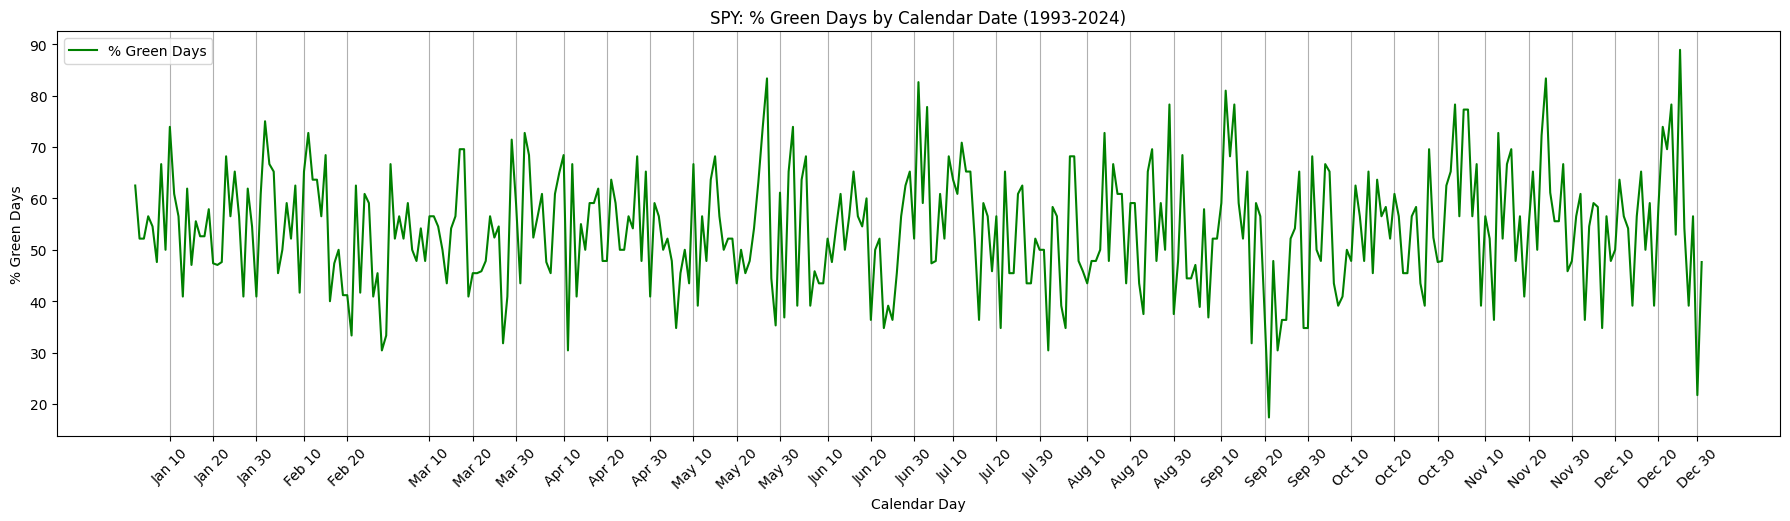

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,5))
plt.plot(calendar_stats.index, calendar_stats['green_pct'], label='% Green Days', color='green')
plt.title("SPY: % Green Days by Calendar Date (1993-2024)")
plt.ylabel('% Green Days')
plt.xlabel('Calendar Day')
plt.grid(True, axis='x')
plt.legend()
plt.tight_layout()

plt.xticks(xtick_locs, xtick_labels, rotation=45, fontsize=10)

plt.savefig('spy_green_days_by_custom_xticks.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
from google.colab import files
files.download('spy_green_days_by_custom_xticks.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>